In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# We have to predict the output/test on the 15 days after the training data last date (as per the competition rules)

In [9]:
#import important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



#let's get into the data directory
dataDir = r'../input/store-sales-time-series-forecasting'

In [10]:
#let's see the training data
store_sales = pd.read_csv(
    dataDir + '/train.csv'
)

In [11]:
#Let's see the columns and their datatypes
store_sales.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

###### About the columns in the dataset, taken from the competition page

* store_nbr identifies the store at which the products are sold 
* family identifies the type of product sold.
* sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.



In [12]:
#The id column is redundant and does not add anything important to our analysis
#Also, we have to infer the date as a datetime object for time series analysis
storeSales = pd.read_csv(
    dataDir + '/train.csv',
    #drop id column
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    #define categorical data type for object variables
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion' : 'int64',
    },
    #parse the date column as a date
    parse_dates=['date'],
)

In [13]:
storeSales

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,2013-01-01,1,BABY CARE,0.000000,0
2,2013-01-01,1,BEAUTY,0.000000,0
3,2013-01-01,1,BEVERAGES,0.000000,0
4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8


In [14]:
#The frequency of Dataset is "D" frequency
storeSales['date'] = storeSales.date.dt.to_period('D')
storeSales = storeSales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [15]:
storeSales

sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]

In [16]:
salesAveraged = (
    storeSales
    .groupby('date').mean()
    .squeeze()
)

In [17]:
#complete data of the sales for the last 4 years averaged over the date
#for all commodities and stores
salesAveraged

,sales,onpromotion
date,,
2013-01-01,1.409438,0.000000
2013-01-02,278.390808,0.000000
2013-01-03,202.840195,0.000000
2013-01-04,198.911163,0.000000
2013-01-05,267.873260,0.000000
...,...,...
2017-08-11,463.733856,7.956790
2017-08-12,444.798309,4.664422
2017-08-13,485.768616,5.209315


In [18]:
from learntools.time_series.style import * 
from learntools.time_series.utils import plot_periodogram, seasonal_plot

In [19]:
salesAvgFramed = salesAveraged['sales'].to_frame()

<Axes: title={'center': 'Seasonal Plot (year/day)'}, xlabel='day', ylabel='sales'>

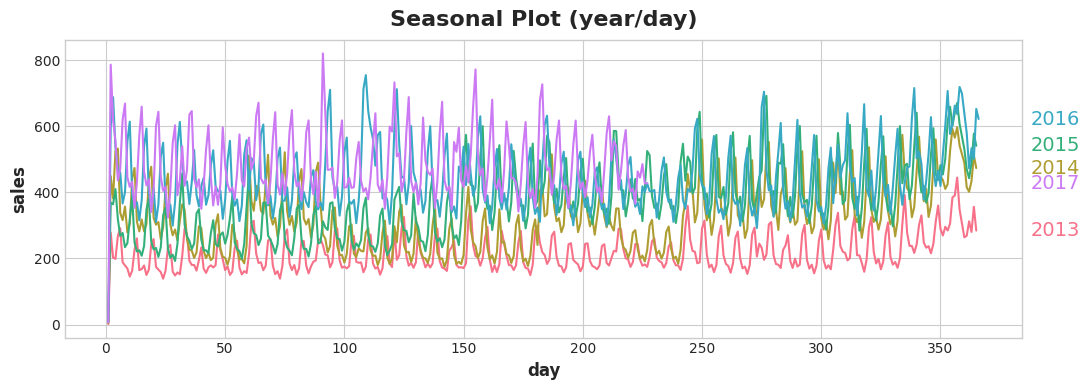

In [20]:
#since date is an index
salesAvgFramed["year"] = salesAvgFramed.index.year
salesAvgFramed["day"] = salesAvgFramed.index.dayofyear
#use the seasonal plot method from the learnutils library
seasonal_plot(salesAvgFramed, y='sales', period='year', freq='day')

##### There is no strong long term seasonality over complete year, seasonality can be seen in some short periods of a year, like a week or over a month. Let's see a more fine seasonality over the week.

<Axes: title={'center': 'Seasonal Plot (week/dayofweek)'}, xlabel='dayofweek', ylabel='sales'>

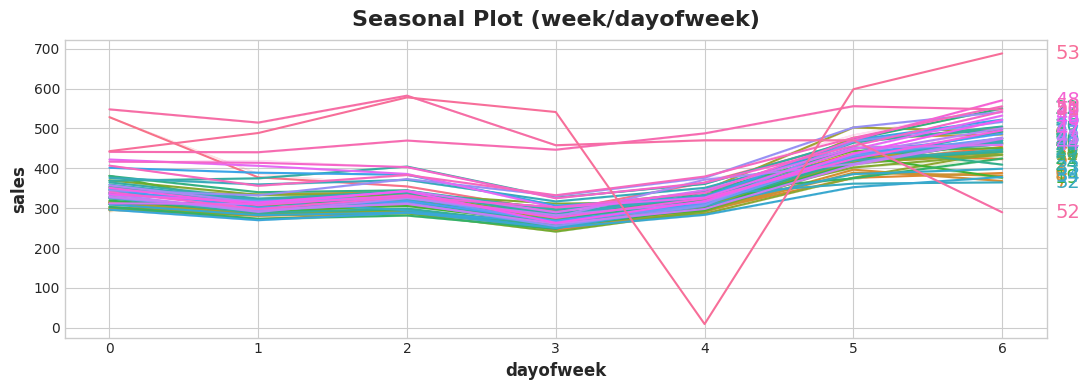

In [21]:
#since date is an index
salesAvgFramed["week"] = salesAvgFramed.index.week
salesAvgFramed["dayofweek"] = salesAvgFramed.index.dayofweek
#use the seasonal plot method from the learnutils library
seasonal_plot(salesAvgFramed, y='sales', period='week', freq='dayofweek')

###### As expected, over the week timeframe, the plots depict that the weekends have higher sales than weekdays. So there is a strong weekly seasonality. 

#### Let's plot the periodogram to see the sources of seasonality, "the occuring periods with common trends"

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

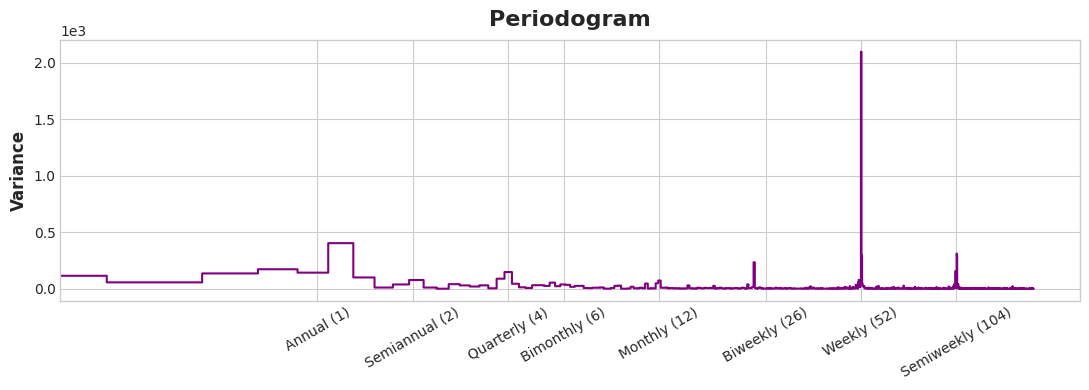

In [22]:
salesAvg = salesAveraged['sales']
plot_periodogram(salesAvg)

### From the complete 4 years of data, Strong weekly component is available and a monthly component too, Quaterly variation is also ther non-zero (while the value is very small)!

In [23]:
#get the date for the year of 2017 to perform the fitting
salesAveraged2017 = salesAveraged.query('date >= "2017-01-01"')

In [24]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
#For monthly features, add the order 4 term to capture biweekly & Weekly seasonality
fourierM = CalendarFourier('M', 4)
#For annual features, add the order 12 term to capture quaterly and Monthly seasonality
fourierA = CalendarFourier('A', 12)

In [25]:
detProcess = DeterministicProcess(
    index=salesAveraged2017.index,
    constant=True,
    order=1,
    #add weekly seasonality
    seasonal = True,
    #adding the quaterly and monthly terms
    additional_terms = [fourierM, fourierA],
    #DROP collinear terms
    drop=True
)
#create a set for training purposes
trainData = detProcess.in_sample()


In [26]:
trainData

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)","sin(11,freq=A-DEC)","cos(11,freq=A-DEC)","sin(12,freq=A-DEC)","cos(12,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220,0.188227,0.982126,0.205104,0.978740
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317,0.369725,0.929141,0.401488,0.915864
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589,0.538005,0.842942,0.580800,0.814046
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157,0.687053,0.726608,0.735417,0.677615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,-0.746972,0.664855,0.162807,-0.986658,0.493776,0.869589,-0.930724,-0.365723,0.953681,-0.300820
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,-0.648630,0.761104,0.008607,-0.999963,0.635432,0.772157,-0.982927,-0.183998,0.871706,-0.490029
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,-0.538005,0.842942,-0.145799,-0.989314,0.758306,0.651899,-0.999991,0.004304,0.752667,-0.658402


In [27]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
model = LinearRegression(fit_intercept=False).fit(trainData, salesAveraged2017['sales'])

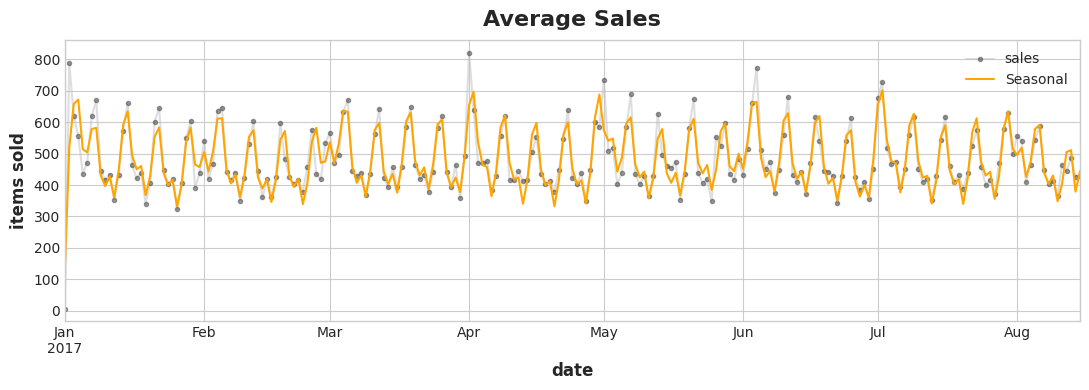

In [28]:
predictedVals = pd.Series(model.predict(trainData), index=trainData.index)
ax = salesAveraged2017['sales'].plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = predictedVals.plot(ax=ax, label="Seasonal", color="orange")
ax.legend()

#### Seems a good fit on the training, but still there are residuals

#### It is important to remove the seasonality trend from the data, so we can move further towards application of the error and residual fitting

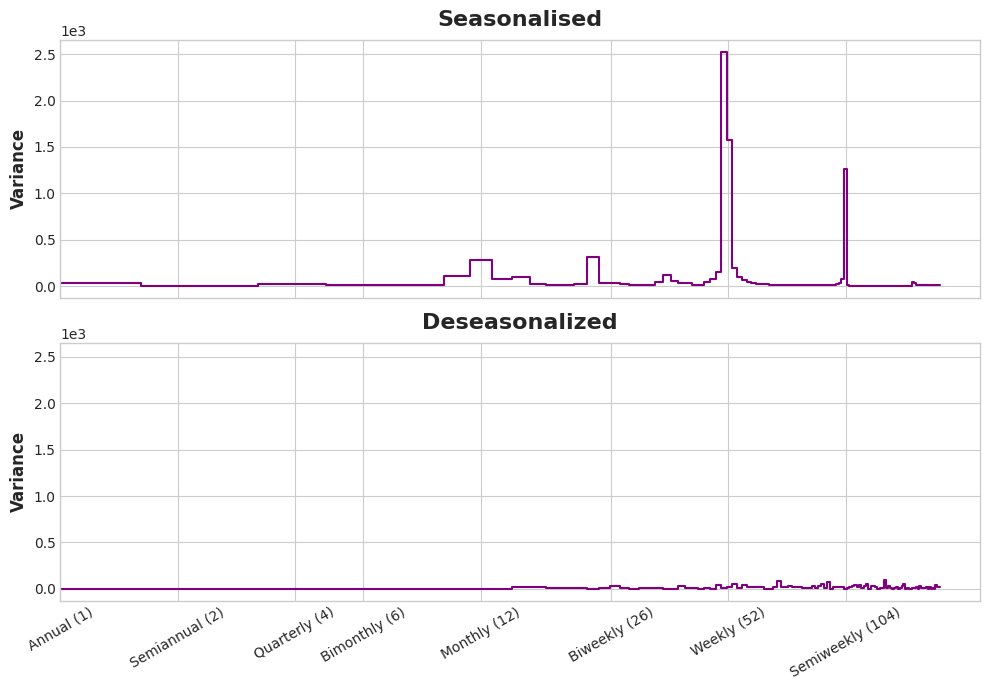

In [29]:
deseasonedVals = salesAveraged2017['sales'] - predictedVals

#plot the figures
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(predictedVals, ax=ax1)
ax1.set_title("Seasonalised")
ax2 = plot_periodogram(deseasonedVals, ax=ax2);
ax2.set_title("Deseasonalized");

##### Also we need to have to apply exogeneous time series forecasting methods in such cases because there are a wide variety of parameters (given in other files) that overall affect the change in the sales. Let's see the other files data

In [30]:
#starting with the holiday dataset because holidays affect the 
#store sales due to varying consumer behaviour during holidays
holidays = pd.read_csv(dataDir+"/holidays_events.csv")
print(holidays.head())
holidays.dtypes

         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

In [31]:
#parse the datatypes with correct datatypes and also the date as datetime
holidays = pd.read_csv(
    dataDir+ "/holidays_events.csv",
    #change the object types to 
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    #transferred is a promising column because
    #if a holiday is transferred then at day consumer behaviour will become
    #highly stochastic because the consumer may have holiday plans but then
    #it was changed to a normal day
    usecols = ['date', 'type', 'locale', 'locale_name', 'description', 'transferred'],
    parse_dates=['date']
)
holidays = holidays.set_index('date').to_period('D')

In [32]:
holidays

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [33]:
holidays.query('date >= "2017-08-16"')

,type,locale,locale_name,description,transferred
date,,,,,
2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False
2017-09-28,Holiday,Local,Ibarra,Fundacion de Ibarra,True
2017-09-29,Transfer,Local,Ibarra,Fundacion de Ibarra,False
2017-10-07,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False
2017-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
2017-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2017-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
2017-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False
2017-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False


In [34]:
# Since we have averaged the sales, it is important to basically analyze
# on the overall national and regional holidays, because the local holidays 
# will be celebrated on a very limited region only
holidays2017 = (
    holidays
    .query("locale in ['National', 'Regional']")
    #get the dates in 2017 only till the date where training data lies
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays2017)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


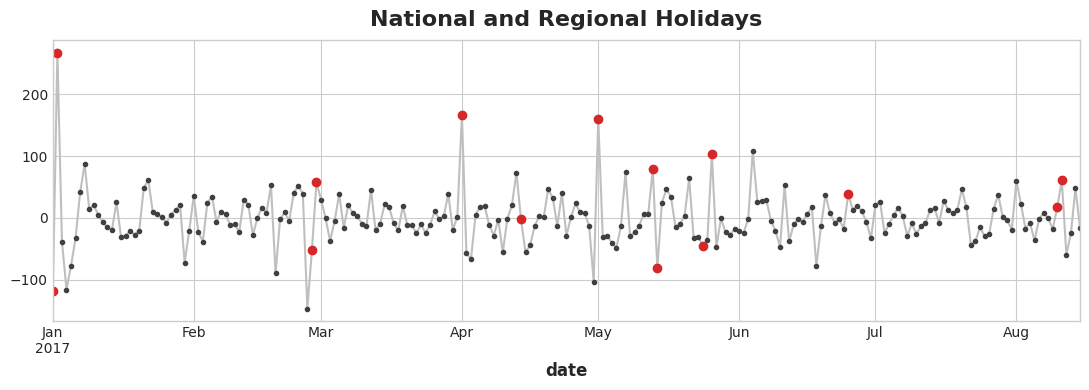

In [35]:
ax = deseasonedVals.plot(**plot_params)
plt.plot_date(holidays2017.index, deseasonedVals[holidays2017.index], color='C3')
ax.set_title('National and Regional Holidays');

In [36]:
#Apply one hot encoding to each of these categories to create a set of features
#for the categorical data
trainDataHolidays2017 = pd.get_dummies(holidays2017)
#directly the get_dummies function from the pandas library can be used

trainDataWithHolidays = trainData.join(trainDataHolidays2017, on='date').fillna(0.0)

In [37]:
trainDataWithHolidays

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,False,False,False,True,False,False,False,False,False,False
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,False,False,False,False,False,False,False,False,True,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,False,False,False,False,False,False,False,True,False,False
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


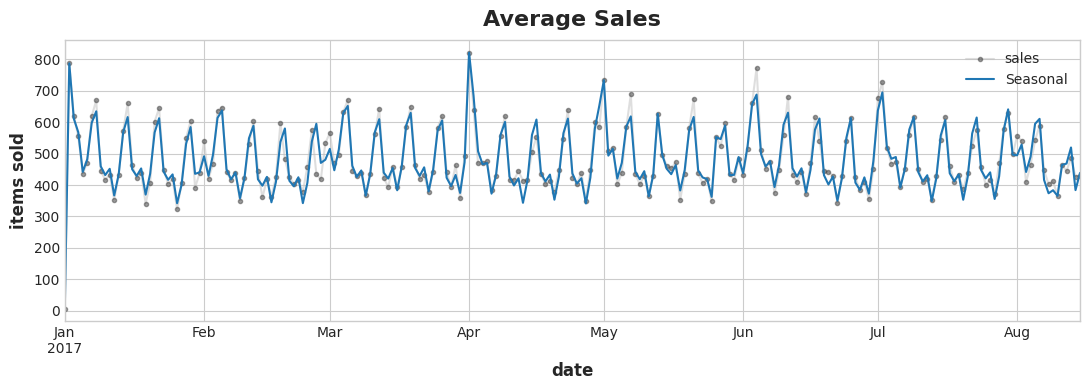

In [38]:
model = LinearRegression(fit_intercept=False).fit(trainDataWithHolidays, salesAveraged2017['sales'])
predValsWithHolidays = pd.Series(model.predict(trainDataWithHolidays), index=trainDataWithHolidays.index)
ax = salesAveraged2017['sales'].plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = predValsWithHolidays.plot(ax=ax, label="Seasonal")
ax.legend();

<Axes: xlabel='store_nbr', ylabel='sales'>

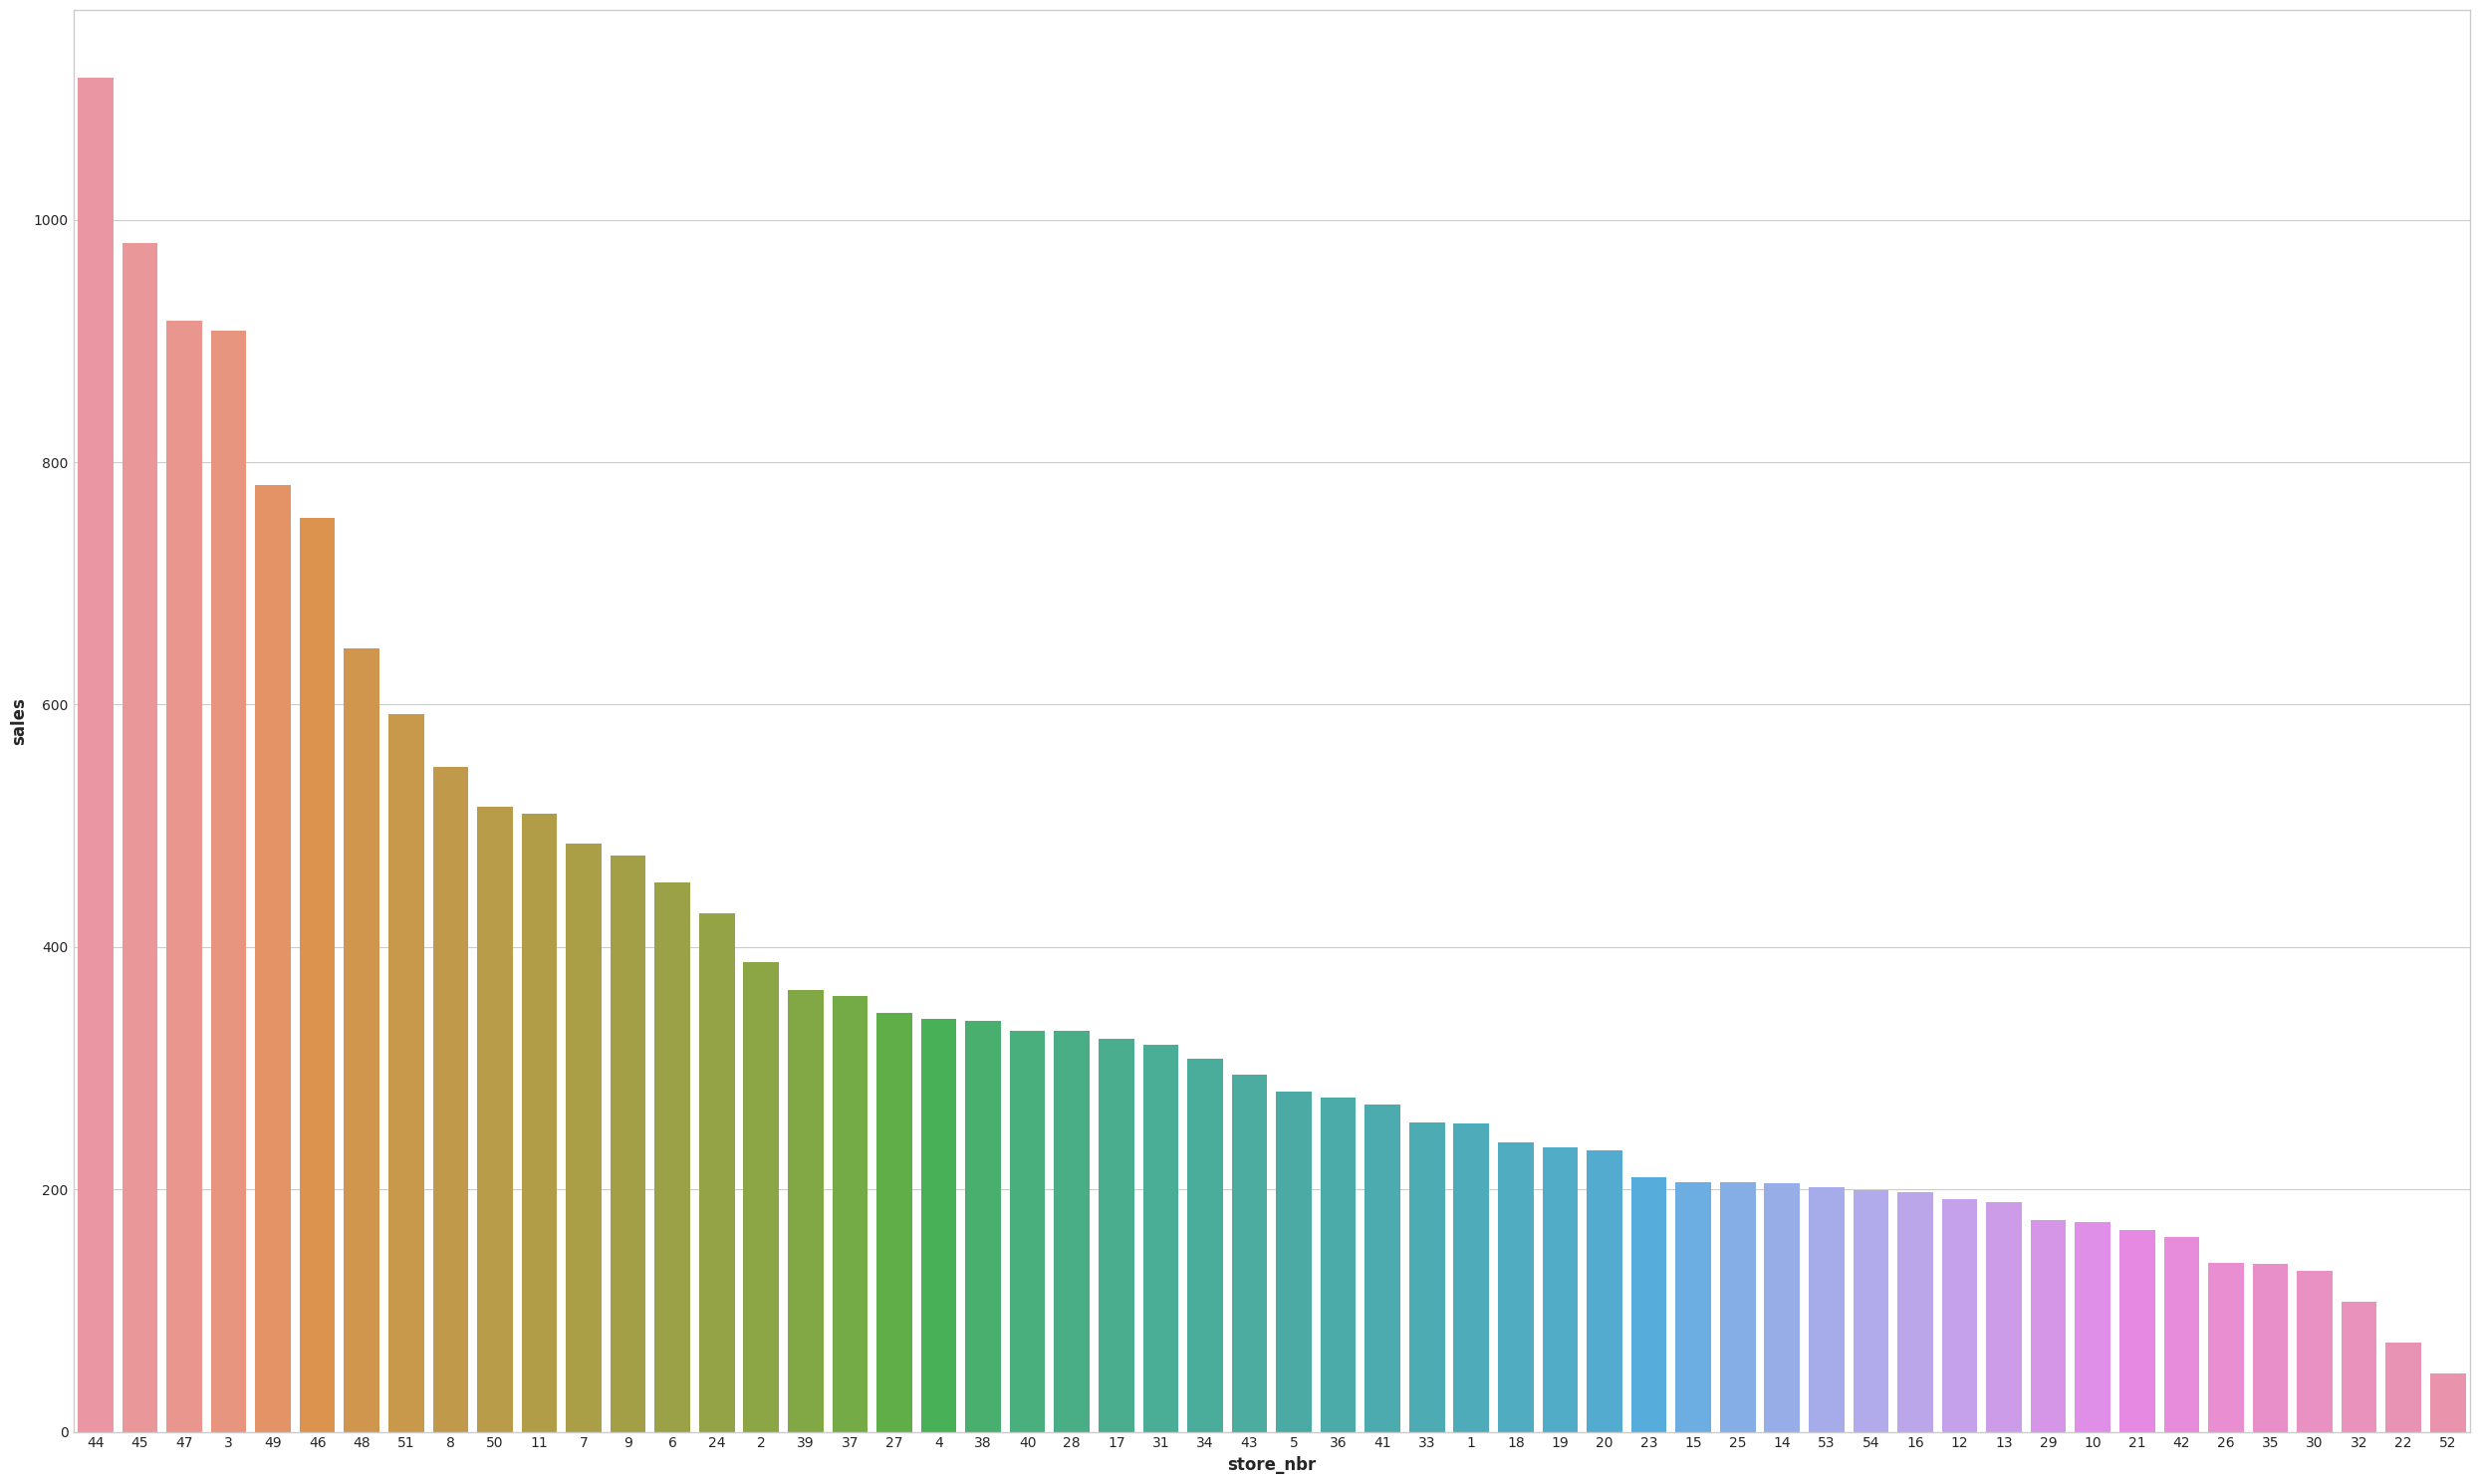

In [60]:
s=pd.read_csv(dataDir+'/train.csv').groupby('store_nbr')['sales'].mean().sort_values(ascending=False)
s=pd.DataFrame(s)
ax,f=plt.subplots(figsize=(25,15))
sns.barplot(x=s.index,y='sales',data=s,ax=None,ci=None,order=s.index)

In [62]:
#Let's see the stores which are the part of the city 'Ambato' having the holiday
#during the duration of test data forecasting horizon
stores=pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
stores[stores['city']=='Ambato']

,store_nbr,city,state,type,cluster
22,23,Ambato,Tungurahua,D,9
49,50,Ambato,Tungurahua,A,14


#### If we carefully analyze the 'holidays' dataset, then we realize that there is only a single holiday in the whole set of duration of the test dataset. That holiday is also just a local holiday. This brings us to a smart decision to not merge the holidays dataset because it will cause model to learn a lot of new features and may cause underfit over important variables. Also, from the average sales, it can be seen that Stores 50 and 23 are both having sales less than half of the maximum, so the idea of holidays can be safely excluded here.

In [136]:
oil=pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv', parse_dates = ['date'])

transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')

In [137]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [138]:
#fill the NaN values with mean
oil = oil.set_index('date').to_period('D')
oil['dcoilwtico'].fillna(oil[(oil.index) >= '2016-12-31']['dcoilwtico'].mean(), inplace=True)
oil

In [119]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [118]:
stores['city'].value_counts()

city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: count, dtype: int64

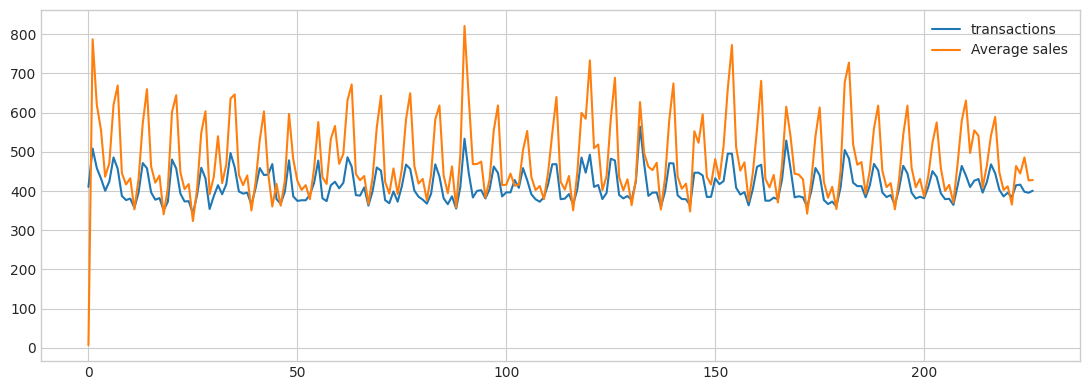

In [198]:
plt.plot(0.25*np.array(transactions.query('date >= "2017-01-01"')[['date', 'transactions']].groupby('date').mean()['transactions']))
plt.plot(np.array(salesAveraged2017['sales']))
plt.legend(["transactions", "Average sales"])

##### As expected, the transactions are strongly positively correlated with the average sales, because higher the number of transactions, more one will expect the overall sales. The transactions does not directly help us here because it is also not available in the test period, so we have to predict transactions and then correlate it with sales. 

In [152]:
dumm = salesAveraged2017.join(oil).fillna(0.0)

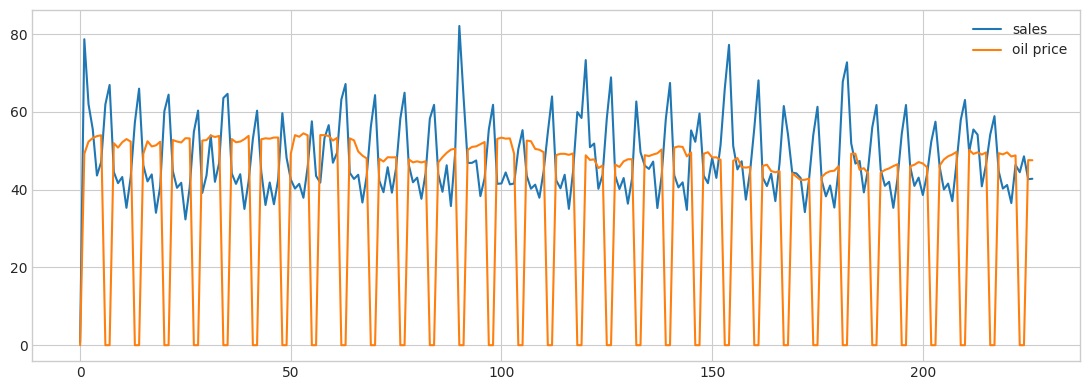

In [157]:
plt.plot(0.1*np.array(dumm['sales']))
plt.plot(np.array(dumm['dcoilwtico']))
plt.legend(['sales', 'oil price'])

#### Oil after filling the Nan with zero can be a good estimator because it can be seen that the peaks occurs ehere the values of oil prices is not available, there may some correlation that oil prices on Nan days were basically low that the advisors really didn't care to record those values. Due to low prices, the users were really optimistic (have more money to spend) to purchase other goods

# LinearRegression and XGBoost for fitting the model
#### Comment out the XGBoost lines to obtain only the Linear Regressor

In [228]:
y = storeSales.drop(['onpromotion'], axis=1).unstack(['store_nbr', 'family']).loc["2017"]


# Create training data
fourierM = CalendarFourier(freq='M', order=2)
fourierA = CalendarFourier(freq='A', order=12)
dp = DeterministicProcess(
    index=y.index,
    constant=False,
    order=1,
    seasonal=True,
    additional_terms=[fourierM],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)
X = X.join(oil).fillna(0.0)

In [229]:
from sklearn.preprocessing import LabelEncoder
family_sales = (
    storeSales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [230]:
X_2

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1
...,...,...,...
2017-08-15,28,0.111111,15
2017-08-15,29,0.166667,15
2017-08-15,30,58.685185,15


In [232]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
model2 = XGBRegressor()
model2.fit(X_2, (y-y_pred).stack().squeeze())
y_fin = y_pred.stack().squeeze() + model2.predict(X_2)

In [239]:
y_fin

sales                           \
store_nbr                                        1          10           11   
date       family                                                             
2017-01-01 AUTOMOTIVE                     1.547171    0.892820     1.601693   
           BABY CARE                      1.547171    0.892820     1.601693   
           BEAUTY                         1.547171    0.892820     1.601693   
           BEVERAGES                      3.349558    2.292380    10.627142   
           BOOKS                          2.349919    1.758862     1.601693   
...                                            ...         ...          ...   
2017-08-15 POULTRY                      301.750643  126.253094   409.252593   
           PREPARED FOODS                50.198087   20.585242   113.854749   
           PRODUCE                     2202.400647  250.252463  2315.679085   
           SCHOOL AND OFFICE SUPPLIES    -8.903536    1.538487    27.261135   
           SEAFOOD                       21.902714    1.605860    21.292927   

                                                                           \
store_nbr                                      12          13          14   
date       family                                                           
2017-01-01 AUTOMOTIVE                    1.513587    0.089134    1.167172   
           BABY CARE                     1.513587    0.089134    1.167172   
           BEAUTY                        1.513587    0.089134    1.167172   
           BEVERAGES                     6.369575    1.108089    1.280316   
           BOOKS                         1.634074    0.089134    1.167172   
...                                           ...         ...         ...   
2017-08-15 POULTRY                     137.254346   87.322351   64.901290   
           PREPARED FOODS               30.130694   19.073457   93.382865   
           PRODUCE                     411.869384  307.496925  528.785881   
           SCHOOL AND OFFICE SUPPLIES    2.618635    5.173037    1.312935   
           SEAFOOD                       5.422110    2.940592    3.883983   

                                                                             \
store_nbr                                       15          16           17   
date       family                                                             
2017-01-01 AUTOMOTIVE                     1.422845    0.670240     0.216504   
           BABY CARE                      1.422845    0.670240     0.216504   
           BEAUTY                         1.422845    0.670240     0.216504   
           BEVERAGES                      7.515506   -0.515044     4.174108   
           BOOKS                          1.793087    0.670240     0.661129   
...                                            ...         ...          ...   
2017-08-15 POULTRY                      118.480726   66.511561   351.975631   
           PREPARED FOODS                50.269772   30.699205    47.141574   
           PRODUCE                     1067.505007  896.714044  2294.745622   
           SCHOOL AND OFFICE SUPPLIES     1.588044    1.804432    17.008318   
           SEAFOOD                        4.885073    1.286216    15.608474   

                                                    ...               \
store_nbr                                       18  ...            5   
date       family                                   ...                
2017-01-01 AUTOMOTIVE                     1.627865  ...    -0.358345   
           BABY CARE                      1.627865  ...    -0.358345   
           BEAUTY                         1.627865  ...    -0.358345   
           BEVERAGES                      1.063684  ...    -3.796405   
           BOOKS                          1.981185  ...    -0.081420   
...                                            ...  ...          ...   
2017-08-15 POULTRY                      163.876083  ...   211.986977   
           PREPARED FOODS       

In [233]:
df_test = pd.read_csv(
    dataDir+ '/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [234]:
df_test

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [235]:
family_sales = (
    df_test
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
)
X_2 = family_sales.stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month
X_2.drop(['id'], axis=1,inplace=True)

In [236]:
X_2

,family,onpromotion,day
date,,,
2017-08-16,0,0.000000,16
2017-08-16,1,0.000000,16
2017-08-16,2,2.000000,16
2017-08-16,3,31.592593,16
2017-08-16,4,0.000000,16
...,...,...,...
2017-08-31,28,0.388889,31
2017-08-31,29,0.111111,31
2017-08-31,30,3.351852,31


In [237]:
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)
X_test = X_test.join(oil, on="date").fillna(0.0)

In [252]:
# Create features for test set
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack().squeeze() + model2.predict(X_2)
y_submit = y_submit.unstack().stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

In [253]:
y_submit

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     5.761780
                     BABY CARE                   3000889     1.686887
                     BEAUTY                      3000890    -5.162505
                     BEVERAGES                   3000891  2491.663996
                     BOOKS                       3000892     1.930667
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   344.390484
                     PREPARED FOODS              3029396    85.667907
                     PRODUCE                     3029397  1210.130349
                     SCHOOL AND OFFICE SUPPLIES  3029398    30.481537
                     SEAFOOD                     3029399     8.321077

[28512 rows x 2 columns]